# CW1 - Multimodal Classification of New York Times News Sections Using Images and Captions with Keras

## Introduction

In this assignment you will be provided a dataset containing a selection of images in JPEG image format and together with their caption in text format from articles appearing on the web site of the New York Times.


![Example](https://i.ibb.co/67v6LVV8/Screenshot-2025-09-11-151406.png)


You will be analysing this dataset by implementing and training two models: a **CNN** and an **LSTM**.

The CNN must classify images by the section they appear in. Independently, the LSTM must classify images captions by the section. Finally, you will evaluate and critically comment your results in a short report. Use the Google Colab notebook provided, and prepare a 2-3 pages report that critically evaluates the model. (Which of the two modalities was better for classifying images?)

## Structure of the assignment

This assignment is broken up into sections and you need to complete each section successively. The sections are the following:

1. Data Processing

  1.a. Image processing of the images

  1.b. Natural language processing of the captions

2. Models Definition

  2.a. CNN for the images

  2.b. LSTM for the captions

3. Models Training
4. Models Evaluation

In addition to this coding exercise, you must write a **2-page** report analysing and critically evaluating your model's results. Marks for the report will be awarded for depth of analysis and critical thinking skills. You should consider how well your model performs and WHY it does that—give specific examples and comment on their importance.

In [1]:
# Enter your module imports here, many modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pathlib
import pandas as pd
import tarfile
from tensorflow import keras
from pathlib import Path
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

In [2]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Processing



In [3]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

DATA_TAR  = Path("/content/drive/MyDrive/dataset/Multimodal_NYT_dataset.tar")
DATA_ROOT = Path("./Multimodal_NYT_dataset")
IMAGES_DIR = DATA_ROOT / "NYT_imgs"
CSV_PATH   = DATA_ROOT / "NYT_dataset.csv"

# Error message if Multimodal_NYT_dataset.tar not found
assert DATA_TAR.exists(), "Please, upload Multimodal_NYT_dataset.tar to Google Drive in MyDrive"

if not DATA_ROOT.exists():
    with tarfile.open(DATA_TAR, "r:") as tarf:
        tarf.extractall(path=".")
    print(f"Extracted {DATA_TAR.name}")

# Error message if NYT_imgs/ and NYT_dataset.csv not found in the tar file
assert IMAGES_DIR.exists() and CSV_PATH.exists(), "Multimodal_NYT_dataset.tar must contain NYT_imgs/ and NYT_dataset.csv"

print("Staging complete.")

/tmp/ipython-input-33249260.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tarf.extractall(path=".")


Extracted Multimodal_NYT_dataset.tar
Staging complete.


In [4]:
# CodeGrade Tag Init3
# Do not edit, remove, or copy this cell

DATA_ROOT  = Path("./Multimodal_NYT_dataset")
CSV_PATH   = DATA_ROOT / "NYT_dataset.csv"
IMAGES_DIR = DATA_ROOT / "NYT_imgs"
ID_COL     = "image_id"

assert CSV_PATH.exists(), f"CSV not found at {CSV_PATH}."
assert IMAGES_DIR.exists(), f"Images folder not found at {IMAGES_DIR}."


### 1.a. Image processing of the images

* **Load the dataset from the path ``CSV_PATH`` by using pd.read_csv and split it into training and testing with test size 20%**


In [5]:
# CodeGrade Tag Ex1a-i
### Load the dataset from the path CSV_PATH by using pd.read_csv and split it
### into training and testing with test size 20%

dataset = pd.read_csv(CSV_PATH)

data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2, random_state=42)

* **Use a OneHotEncoder to convert the target feature ''section'' into numeric One-Hot labels. Then, as a sanity check, count the number of different sections and save it in ``sections_number``** (the result has to be 24).

In [6]:
# CodeGrade Tag Ex1a-ii
### Use a OneHotEncoder to convert the target feature ''section'' into numeric
### One-Hot labels. Then, as a sanity check, count the number of different
### sections and save it in ``sections_number``** (the result has to be 24)

sections_all = np.array(sorted(dataset["section"].dropna().unique())).reshape(-1, 1)

ohe = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)
ohe.fit(sections_all)

labels_train = ohe.transform(data_train["section"].to_numpy().reshape(-1, 1))
labels_test  = ohe.transform(data_test["section"].to_numpy().reshape(-1, 1))

sections_names  = ohe.get_feature_names_out(["section"])

sections_number = len(sections_names)

In [7]:
# CodeGrade Tag Init4
# Do not edit, remove, or copy this cell

# Obtain clean captions with NaN-free string ndarrays
captions_train = pd.Series(data_train["caption"], dtype="object").fillna("").astype(str).to_numpy()
captions_test  = pd.Series(data_test["caption"],  dtype="object").fillna("").astype(str).to_numpy()

# Index the images folder
allowed_exts = {".jpg", ".jpeg", ".png", ".jfif", ".webp"}
img_index = {}
for p in IMAGES_DIR.iterdir():
    if p.is_file() and p.suffix.lower() in allowed_exts:
        img_index[p.stem] = str(p)

print(f"Indexed {len(img_index):,} images from {IMAGES_DIR}")

# Remap IDs to existing files (and drop rows with missing images)
def remap_paths(frame, labels, captions, *, id_col=ID_COL):
    ids = frame[id_col].astype(str).str.strip().to_numpy()
    mask = np.array([i in img_index for i in ids])
    dropped = int((~mask).sum())
    if dropped:
        missing_ids = [ids[i] for i in np.where(~mask)[0][:3]]
        print(f"Dropping {dropped} rows with missing images.")
    paths = np.array([img_index[i] for i in ids[mask]], dtype=object)
    labels = labels[mask].astype("float32")
    captions = captions[mask]
    frame = frame.iloc[np.where(mask)[0]].reset_index(drop=True)

    return frame, paths, labels, captions

data_train, img_locs_train, labels_train, captions_train = remap_paths(
    data_train, labels_train, captions_train
)
data_test,  img_locs_test,  labels_test,  captions_test  = remap_paths(
    data_test,  labels_test,  captions_test
)

# Report final sample counts
print(f"Final sizes — train: {len(img_locs_train)}, validation: {len(img_locs_test)}")

Indexed 61,407 images from Multimodal_NYT_dataset/NYT_imgs
Dropping 6 rows with missing images.
Dropping 2 rows with missing images.
Final sizes — train: 48968, validation: 12242


In [8]:
# CodeGrade Tag Init5
# Do not edit, remove, or copy this cell

# This function is provided to read in the image files from the folder
def parse_image(filename, label):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])  # static shape for tf.data
    return img, label

In [9]:
# CodeGrade Tag Init6
# Do not edit, remove, or copy this cell

# Create the initial datasets of images
list_images_train_ds = tf.data.Dataset.from_tensor_slices(
    (img_locs_train, labels_train.astype("float32"))
)
list_images_valid_ds = tf.data.Dataset.from_tensor_slices(
    (img_locs_test, labels_test.astype("float32"))
)

* **Create a function called ```img_resize``` converts the images to float32 datatype and resizes them to 128x256 pixels.**

In [10]:
# CodeGrade Tag Ex1a-iii
### Write a function call img_process that resizes the image to 128x256, and
### converts the data type of the images to tf.float32

def img_process(image, label):
    image = tf.image.resize(image, [128, 256])
    image = tf.cast(image, tf.float32)
    return image, label

* **Using the ``tf.data`` API, load in the training and validation data for the images. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [11]:
# CodeGrade Tag Ex1a-iv
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 32.

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

imagess_train_ds = list_images_train_ds \
    .map(parse_image, num_parallel_calls=AUTOTUNE) \
    .cache() \
    .shuffle(buffer_size=1000) \
    .batch(BATCH_SIZE) \
    .map(img_process, num_parallel_calls=AUTOTUNE) \
    .prefetch(buffer_size=AUTOTUNE)


images_valid_ds = list_images_valid_ds \
    .map(parse_image, num_parallel_calls=AUTOTUNE) \
    .cache() \
    .batch(BATCH_SIZE) \
    .map(img_process, num_parallel_calls=AUTOTUNE) \
    .prefetch(buffer_size=AUTOTUNE)

### 1.b. Natural Language processing of the captions

* Build the vocabulary of the model by calling the ``encoder.adapt()`` method on the captions train data. Make sure the output sequence lenght is fixed and it is ``SEQ_LEN``.

In [12]:
# CodeGrade Tag Ex1b-i
### Build the vocabulary of the model by calling the encoder.adapt() method on
### the captions train data. Make sure the output sequence lenght is fixed and
### it is SEQ_LEN.

VOCAB_SIZE = 10000
SEQ_LEN = 200

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_sequence_length=SEQ_LEN
)

encoder.adapt(captions_train)

* Print the first 200 words of the vocabulary you obtained.

In [13]:
# CodeGrade Tag Ex1b-ii
### Print the first 200 words of the vocabulary you obtained.

print(encoder.get_vocabulary()[:200])

['', '[UNK]', np.str_('the'), np.str_('in'), np.str_('a'), np.str_('of'), np.str_('and'), np.str_('at'), np.str_('to'), np.str_('on'), np.str_('for'), np.str_('from'), np.str_('with'), np.str_('is'), np.str_('new'), np.str_('by'), np.str_('left'), np.str_('an'), np.str_('that'), np.str_('his'), np.str_('as'), np.str_('was'), np.str_('has'), np.str_('her'), np.str_('said'), np.str_('he'), np.str_('this'), np.str_('will'), np.str_('its'), np.str_('it'), np.str_('are'), np.str_('be'), np.str_('who'), np.str_('which'), np.str_('york'), np.str_('their'), np.str_('one'), np.str_('center'), np.str_('have'), np.str_('last'), np.str_('after'), np.str_('president'), np.str_('she'), np.str_('about'), np.str_('but'), np.str_('during'), np.str_('theater'), np.str_('home'), np.str_('been'), np.str_('more'), np.str_('city'), np.str_('had'), np.str_('first'), np.str_('year'), np.str_('right'), np.str_('show'), np.str_('not'), np.str_('company'), np.str_('trump'), np.str_('were'), np.str_('years'), np.

* **Using the ``tf.data`` API, load in the training and validation data for the captions.**

In [14]:
# CodeGrade Tag Ex1b-iii

# Encode the captions with the TF encoder and cast token IDs to int32
captions_train_ids = tf.cast(encoder(tf.constant(captions_train, dtype=tf.string)), tf.int32)
captions_test_ids  = tf.cast(encoder(tf.constant(captions_test,  dtype=tf.string)), tf.int32)

# Build datasets by pairing encoded captions with their labels
captions_train_ds_raw = tf.data.Dataset.from_tensor_slices((captions_train_ids, labels_train))
captions_valid_ds_raw = tf.data.Dataset.from_tensor_slices((captions_test_ids,  labels_test))

### Construct the training and validation datasets. You should utilise good
### practice in optimising the dataset loading. Use a batch size of 128.

captions_train_ds = captions_train_ds_raw \
    .cache() \
    .shuffle(buffer_size=1000) \
    .batch(128) \
    .prefetch(buffer_size=AUTOTUNE)

captions_valid_ds = captions_valid_ds_raw \
    .cache() \
    .batch(128) \
    .prefetch(buffer_size=AUTOTUNE)

# 2. Models Definition

### 2.a. CNN

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

 Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv0 (Conv2D)                  │ (None, 64, 128, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop1 (Dropout)                 │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 64, 128, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 64, 128, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop2 (Dropout)                 │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 32, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 32, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop3 (Dropout)                 │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 16, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 16, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop4 (Dropout)                 │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 8, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool4 (MaxPooling2D)            │ (None, 4, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flat (GlobalAveragePooling2D)   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop5 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC2 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop6 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 637,272 (2.43 MB)
 Trainable params: 637,272 (2.43 MB)
 Non-trainable params: 0 (0.00 B)


```



In [15]:
# CodeGrade Tag Ex2a-i
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

def build_cnn_model():

  inputs = Input(shape=(128, 256, 3), name="Input")

  # First block of Conv -> Dropout
  x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu', name='Conv0')(inputs)
  x = Dropout(0.2, name='Drop1')(x)

  # Second block of Conv -> Conv -> Dropout -> Pool
  x = Conv2D(32, (3, 3), padding='same', activation='relu', name='Conv1')(x)
  x = Conv2D(32, (3, 3), padding='same', activation='relu', name='Conv2')(x)
  x = Dropout(0.2, name='Drop2')(x)
  x = MaxPooling2D((2, 2), padding='same', name='Pool1')(x)

  # Third block of Conv -> Conv -> Dropout -> Pool
  x = Conv2D(64, (3, 3), padding='same', activation='relu', name='Conv3')(x)
  x = Conv2D(64, (3, 3), padding='same', activation='relu', name='Conv4')(x)
  x = Dropout(0.2, name='Drop3')(x)
  x = MaxPooling2D((2, 2), padding='same', name='pool2')(x)

  # Fourth block of Conv -> Conv -> Dropout -> Pool -> Pool
  x = Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv5')(x)
  x = Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv6')(x)
  x = Dropout(0.2, name='Drop4')(x)
  x = MaxPooling2D((2, 2), padding='same', name='Pool3')(x)
  x = MaxPooling2D((2, 2), padding='same', name='Pool4')(x)

  # Flatten and Dense layers
  x = tf.keras.layers.GlobalAveragePooling2D(name='Flat')(x)
  x = Dense(512, activation='relu', name='FC1')(x)
  x = Dropout(0.5, name='Drop5')(x)
  x = Dense(512, activation='relu', name='FC2')(x)
  x = Dropout(0.5, name='Drop6')(x)

  outputs = Dense(sections_number, activation='sigmoid', name='Output')(x)

  model = Model(inputs=inputs, outputs=outputs)
  return model

cnn_model = build_cnn_model()

* Print the model summary and confirm is has the same architecture as the one provided.

In [16]:
# CodeGrade Tag Ex2a-ii
### Print the model summary and confirm is has the same architecture as the one
### provided.

cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv0 (Conv2D)                  │ (None, 64, 128, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop1 (Dropout)                 │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 64, 128, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 64, 128, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop2 (Dropout)                 │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 32, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 32, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop3 (Dropout)                 │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 16, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 16, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop4 (Dropout)                 │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 8, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool4 (MaxPooling2D)            │ (None, 4, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flat (GlobalAveragePooling2D)   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop5 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC2 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop6 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 637,272 (2.43 MB)

 Trainable params: 637,272 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

* **Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [17]:
# CodeGrade Tag Ex2a-iii
### Compile the model using the Adam Optimizer with a learning rate of 1e-4 and
### binary crossentropy loss function. For the metrics, use the Precision and
### Recall functions.

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[Precision(), Recall()]
)

### 2.b. LSTM model

* Set up the embedding layer by using ```tf.keras.layers.Embedding```. The ```input_dim``` is the length of the vocab, and the ```output_dim``` must be **192**. You should also set ```mask_zero=False```.

In [18]:
# CodeGrade Tag Ex2b-i
### Set up the embedding layer. The input_dim is the length of the vocab, and
### the output_dim must be 192. You should also set mask_zero=False.

embedder = tf.keras.layers.Embedding(VOCAB_SIZE, 192, mask_zero=False)

* Use ```tf.keras.Sequential``` to build a keras sequential model, with the following layers:


  1.   embedder
  2.   SpatialDropout1D layer with rate 0.2
  3.   BiLSTM layer with 256 units, dropout 0.2, recurrent dropout 0.0 (make sure to use the right ```return_sequences``` parametre to be able to stack this layer with the following BiLSTM)
  4.   BiLSTM layer with 128 units, dropout 0.2, recurrent dropout 0.1
  5.   dense layer with 128 units and relu activation function
  6.   dropout with rate 0.4
  7.   dense output layer with 24 units and sigmoid activation function



In [19]:
# CodeGrade Tag Ex2b-ii
### Build a keras sequential model, with the layers provided above.

from tensorflow.keras.layers import SpatialDropout1D, Bidirectional, LSTM

lstm_model = tf.keras.Sequential([
    embedder,
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.0, return_sequences=True)),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.1)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(sections_number, activation='sigmoid')
])

* Print the model summary and confirm is has the same architecture as the outline provided above.

In [20]:
# CodeGrade Tag Ex2b-iii
### Print the model summary and confirm is has the same architecture as the
### outline provided above.

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

* Compile the model with binary crossentropy loss, the adam optimizer, and the accuracy metric

In [21]:
# CodeGrade Tag Ex2b-iv
### Compile the model with binary crossentropy loss, the adam optimizer, and
### the accuracy metric

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3. Models Training

* **Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [22]:
# CodeGrade Tag Ex3a-i
### Create a ModelCheckpoint callback to store the bext weights from the model,
### based on the validation accuracy. Call this callback "checkpoint_callback"

checkpoint_cnn_filepath = '/content/checkpoint_cnn.weights.h5'
checkpoint_lstm_filepath = '/content/checkpoint_lstm.weights.h5'

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cnn_callback = ModelCheckpoint(
    filepath=checkpoint_cnn_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

checkpoint_lstm_callback = ModelCheckpoint(
    filepath=checkpoint_lstm_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

* **Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [23]:
# CodeGrade Tag Ex3a-ii
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.01))

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### 3.a. CNN training

* **Train the CNN model for 25 epochs** (this may take several minutes), **using the callbacks you made previously. Store the losses and metrics to use later.**

In [24]:
# CodeGrade Tag Ex3a-iii
### Train the model for 25 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

cnn_history = cnn_model.fit(
    imagess_train_ds,
    epochs=25,
    validation_data=images_valid_ds,
    callbacks=[checkpoint_cnn_callback, lr_callback]
)

Epoch 1/5
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2827 - precision: 0.0415 - recall: 0.0240
Epoch 1: val_loss improved from inf to 0.23762, saving model to /content/checkpoint_cnn.weights.h5
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 96s 53ms/step - loss: 0.2826 - precision: 0.0415 - recall: 0.0240 - val_loss: 0.2376 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/5
1529/1531 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1738 - precision: 0.3809 - recall: 0.0015
Epoch 2: val_loss improved from 0.23762 to 0.18873, saving model to /content/checkpoint_cnn.weights.h5
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 107s 38ms/step - loss: 0.1738 - precision: 0.3810 - recall: 0.0015 - val_loss: 0.1887 - val_precision: 0.8889 - val_recall: 0.0013 - learning_rate: 1.0000e-04
Epoch 3/5
1530/1531 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1650 - precision: 0.4749 - recall: 0.0072
Epoch 3: val_loss improved from 0.18873 to 0.17860, saving model to /content/checkpoint_cnn.w

* **Train the model for 10 epochs** (this may take several minutes)**, using the callbacks you made previously. Store the losses and metrics to use later.**

In [26]:
# CodeGrade Tag Ex3b-i
# Train the model for 10 epochs.
lstm_history = lstm_model.fit(
    captions_train_ds,
    epochs=10,
    validation_data=captions_valid_ds,
    callbacks=[checkpoint_lstm_callback, lr_callback]
)

Epoch 1/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0555 - loss: 0.1907
Epoch 1: val_loss improved from inf to 0.15546, saving model to /content/checkpoint_lstm.weights.h5
383/383 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - accuracy: 0.0555 - loss: 0.1907 - val_accuracy: 0.1684 - val_loss: 0.1555 - learning_rate: 0.0010
Epoch 2/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1835 - loss: 0.1525
Epoch 2: val_loss improved from 0.15546 to 0.12281, saving model to /content/checkpoint_lstm.weights.h5
383/383 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.1836 - loss: 0.1525 - val_accuracy: 0.3649 - val_loss: 0.1228 - learning_rate: 0.0010
Epoch 3/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4014 - loss: 0.1201
Epoch 3: val_loss improved from 0.12281 to 0.10303, saving model to /content/checkpoint_lstm.weights.h5
383/383 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.4015 - loss: 0.1201 - val_accuracy: 0.5087 - val_loss: 0.1030 - learning_rate: 0.0010
Epoch 4/5
383/

# 4. Models Evaluation

### 4.a. CNN Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

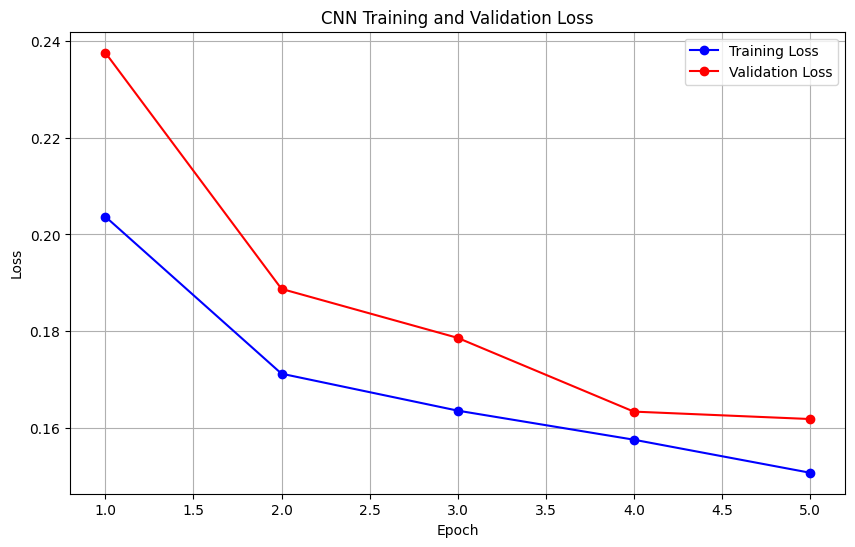

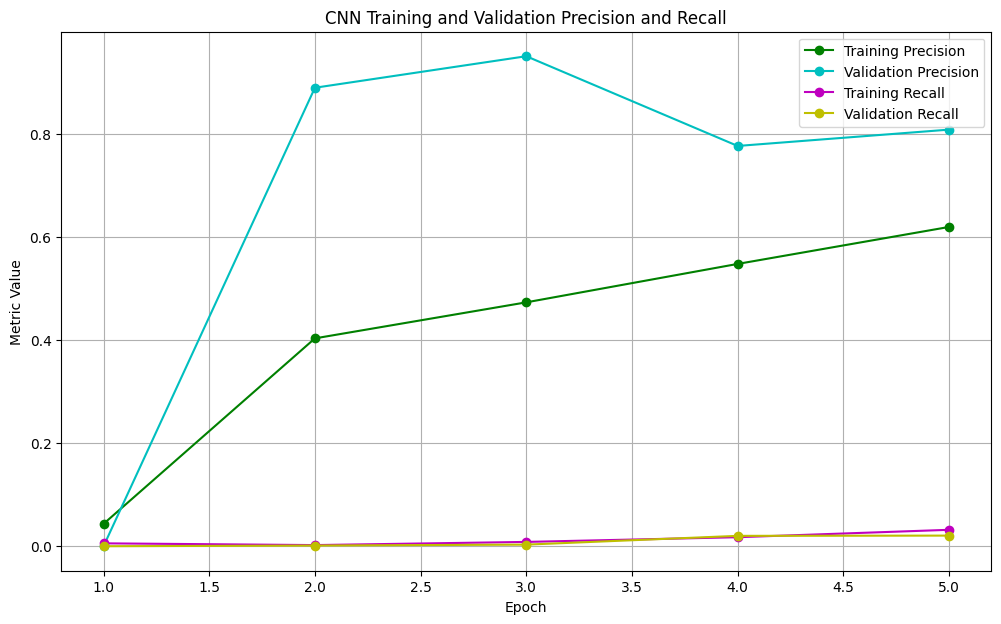

In [28]:
# CodeGrade Tag Ex4a-i

cnn_model.load_weights(checkpoint_cnn_filepath)
print(f"Loaded best weights for CNN model from {checkpoint_cnn_filepath}")

# 1. Extract the training and validation loss, precision, and recall
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
precision = cnn_history.history['precision']
val_precision = cnn_history.history['val_precision']
recall = cnn_history.history['recall']
val_recall = cnn_history.history['val_recall']

epochs = range(1, len(loss) + 1)

# 2. Create the first plot: Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 3. Create the second plot: Training and Validation Precision and Recall
plt.figure(figsize=(12, 7))
plt.plot(epochs, precision, 'go-', label='Training Precision')
plt.plot(epochs, val_precision, 'co-', label='Validation Precision')
plt.plot(epochs, recall, 'mo-', label='Training Recall')
plt.plot(epochs, val_recall, 'yo-', label='Validation Recall')
plt.title('CNN Training and Validation Precision and Recall')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

* **Load the best weights from your model checkpoint, and create plots demonstrating the classification performance for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

### 4.b. LSTM Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

In [ ]:
# CodeGrade Tag Ex4b-i
lstm_model.load_weights(checkpoint_lstm_filepath)
print(f"Loaded best weights for LSTM model from {checkpoint_lstm_filepath}")

loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
accuracy = lstm_history.history['accuracy']
val_accuracy = lstm_history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'go-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'co-', label='Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 4.c. Produce examples for the report

* First, load the best weights from your checkpoints of both your models.

* Choose a few images from the dataset, plot them and print their captions. Use these examples of images and captions to demonstrate the classification performance of the CNN model on the images and of the LSTM model on their captions.

* Be sure to demonstrate the results of the multi-label classification. Compare, for each example image, the top three most probable sections predicted by the CNN and the top three most probable sections predicted by the LSTM, with the ground truth sections.

* Include these examples in your report, and critically evaluate on the performance of the model across the classes.

In [37]:
# CodeGrade Tag Ex4c

cnn_model.load_weights(checkpoint_cnn_filepath)
lstm_model.load_weights(checkpoint_lstm_filepath)

print(f"Loaded best weights for CNN model from {checkpoint_cnn_filepath}")
print(f"Loaded best weights for LSTM model from {checkpoint_lstm_filepath}")

Loaded best weights for CNN model from /content/checkpoint_cnn.weights.h5
Loaded best weights for LSTM model from /content/checkpoint_lstm.weights.h5


In [38]:
# 1. Define a list of indices to select a few diverse examples from the test dataset
example_indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

# 2. From the img_locs_test array, select the image file paths corresponding to example_indices
example_img_locs = img_locs_test[example_indices]

# 3. From the captions_test array, select the captions corresponding to example_indices
example_captions = captions_test[example_indices]

# 4. From the labels_test array, select the one-hot encoded ground truth labels corresponding to example_indices
example_labels_one_hot = labels_test[example_indices]

# 5. Preprocess the selected images for the CNN model
example_images_ds = tf.data.Dataset.from_tensor_slices((example_img_locs, example_labels_one_hot))
example_images_processed = example_images_ds \
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(len(example_indices))

# Convert to a TensorFlow tensor for prediction
example_images_tensor = next(iter(example_images_processed))[0]

# 6. Preprocess the selected captions for the LSTM model
example_captions_encoded = encoder(tf.constant(example_captions, dtype=tf.string))
example_captions_tensor = tf.cast(example_captions_encoded, tf.int32)

# 7. Convert the selected one-hot encoded ground truth labels back to their original section names
example_ground_truth_sections = ohe.inverse_transform(example_labels_one_hot)

print("Example data selected and preprocessed for both models.")
print(f"Selected {len(example_indices)} examples.")

Example data selected and preprocessed for both models.
Selected 10 examples.


In [39]:
# Predict with CNN model
cnn_predictions = cnn_model.predict(example_images_tensor)

# Predict with LSTM model
lstm_predictions = lstm_model.predict(example_captions_tensor)

def get_top_n_predictions(predictions, section_names, n=3):
    top_n_results = []
    for pred in predictions:
        # Get indices that would sort the prediction array in descending order
        sorted_indices = np.argsort(pred)[::-1]
        # Get top n indices
        top_n_indices = sorted_indices[:n]

        # Get corresponding section names and confidence scores
        top_n_sections = [section_names[i].replace('section_', '') for i in top_n_indices]
        top_n_scores = [pred[i] for i in top_n_indices]

        top_n_results.append(list(zip(top_n_sections, top_n_scores)))
    return top_n_results

# Convert sections_names (from ohe.get_feature_names_out) to a simple list of names
all_section_names = ohe.get_feature_names_out(['section'])

cnn_top_3_predictions = get_top_n_predictions(cnn_predictions, all_section_names, n=3)
lstm_top_3_predictions = get_top_n_predictions(lstm_predictions, all_section_names, n=3)

print("Predictions generated for CNN and LSTM models.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
Predictions generated for CNN and LSTM models.


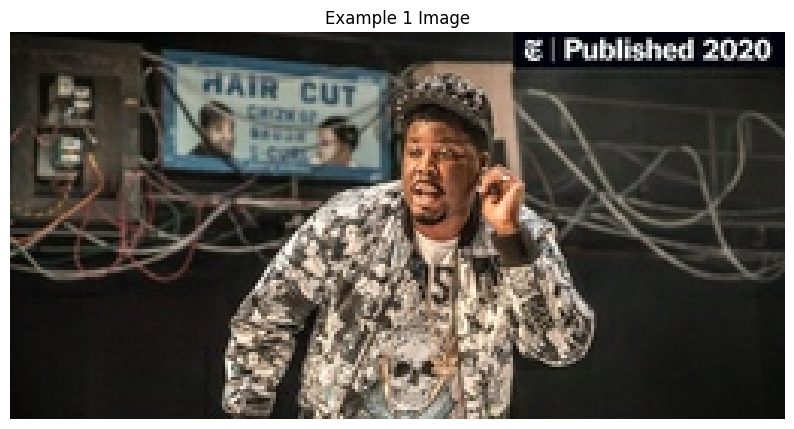

--- Example 1 ---
Original Caption: Hammed Animashaun in &ldquo;Barber Shop Chronicles&rdquo; at the National Theater in London.
Ground Truth Sections: Television

CNN Predictions (Top 3):
- Opinion: 0.2980
- Sports: 0.2498
- Television: 0.1772

LSTM Predictions (Top 3):
- Theater: 0.8697
- Dance: 0.0228
- Movies: 0.0197




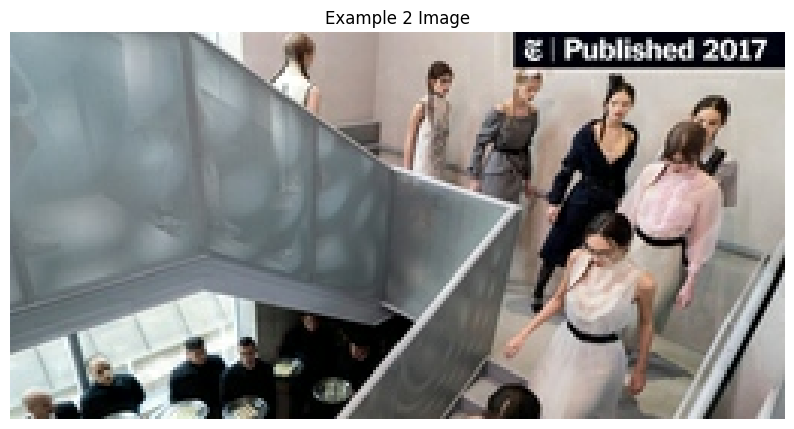

--- Example 2 ---
Original Caption: Prada's 2018 cruise collection, shown in Milan.
Ground Truth Sections: Fashion

CNN Predictions (Top 3):
- Fashion: 0.2392
- Media: 0.1792
- Books: 0.1435

LSTM Predictions (Top 3):
- Fashion: 0.2700
- Style: 0.1485
- Travel: 0.1228




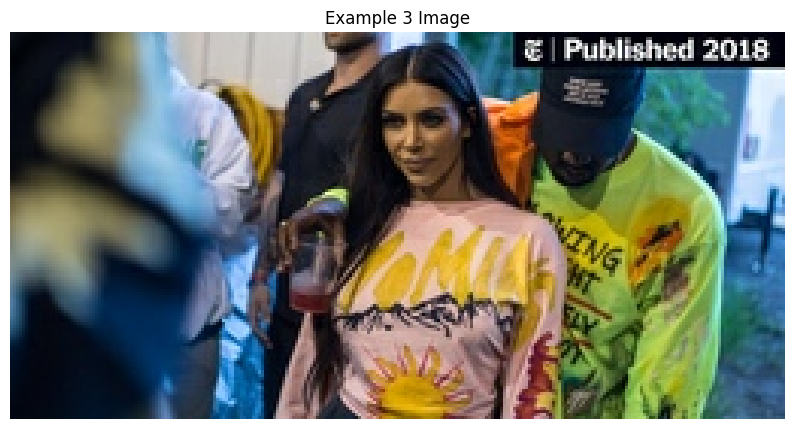

--- Example 3 ---
Original Caption: Kim Kardashian West and Kanye West in the Wyoming-themed merch Mr. West made for his most recent album, "Ye."
Ground Truth Sections: Music

CNN Predictions (Top 3):
- Theater: 0.2021
- Movies: 0.1964
- Television: 0.1947

LSTM Predictions (Top 3):
- Music: 0.7125
- Fashion: 0.0735
- Style: 0.0557




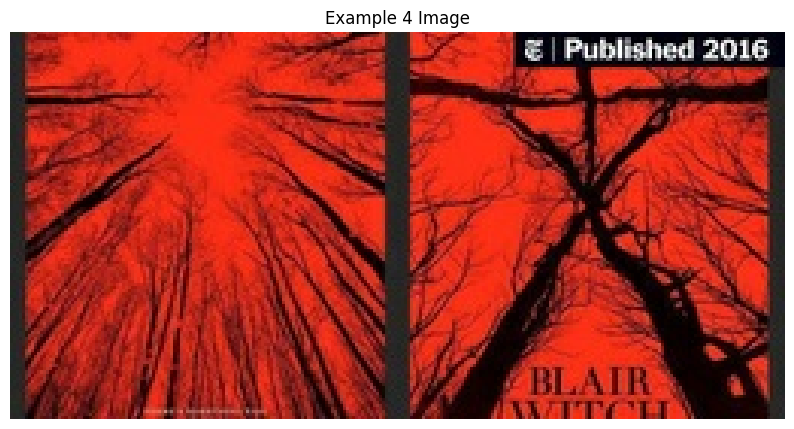

--- Example 4 ---
Original Caption: After a secretive two-year development and production process and a fake marketing campaign for a nonexistent film called "The Woods," a new "Blair Witch" sequel was unveiled.
Ground Truth Sections: Media

CNN Predictions (Top 3):
- Fashion: 0.2864
- Theater: 0.2079
- Media: 0.2053

LSTM Predictions (Top 3):
- Movies: 0.3053
- Theater: 0.2990
- Television: 0.1983




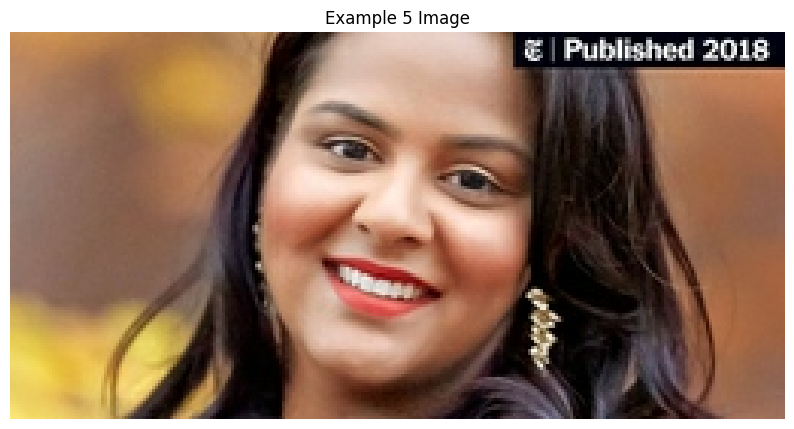

--- Example 5 ---
Original Caption: Krystal A. Sital
Ground Truth Sections: Books

CNN Predictions (Top 3):
- Books: 0.2293
- Movies: 0.1909
- Television: 0.1779

LSTM Predictions (Top 3):
- Travel: 0.2475
- Books: 0.1314
- Opinion: 0.0744




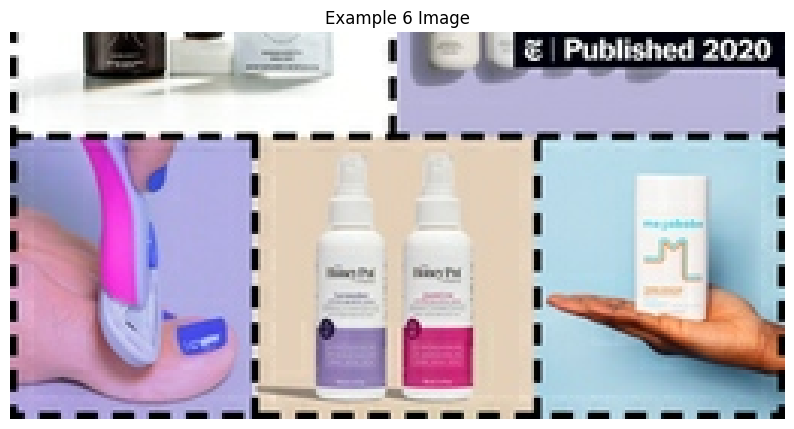

--- Example 6 ---
Original Caption: Clockwise from top left: the Nue Co. gut health line; Jupiter hair-care products; Megababe Thigh Rescue Anti-Friction Stick; feminine products from the Honey Pot Company; and a Billie razor.
Ground Truth Sections: Style

CNN Predictions (Top 3):
- Opinion: 0.3280
- Sports: 0.2271
- Movies: 0.1667

LSTM Predictions (Top 3):
- Science: 0.6121
- Health: 0.2561
- Well: 0.0122




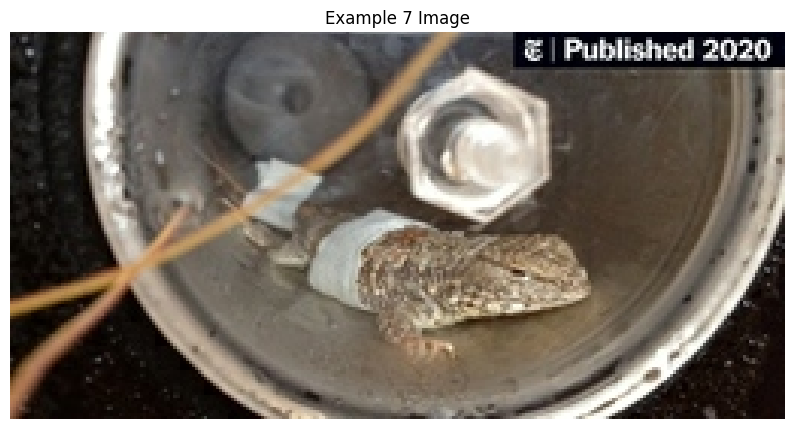

--- Example 7 ---
Original Caption: A very cold female Liolaemus quilmes lizard in an experiment at California State University, Northridge.
Ground Truth Sections: Science

CNN Predictions (Top 3):
- Opinion: 0.2836
- Movies: 0.2185
- Television: 0.1952

LSTM Predictions (Top 3):
- Science: 0.9438
- Health: 0.0265
- Travel: 0.0030




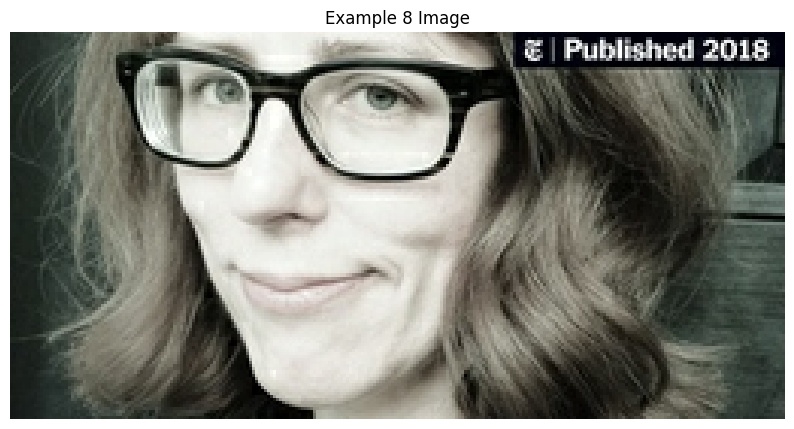

--- Example 8 ---
Original Caption: Malinda McCollum
Ground Truth Sections: Books

CNN Predictions (Top 3):
- Movies: 0.2275
- Books: 0.2108
- Television: 0.1778

LSTM Predictions (Top 3):
- Books: 0.5101
- Food: 0.1016
- Style: 0.0577




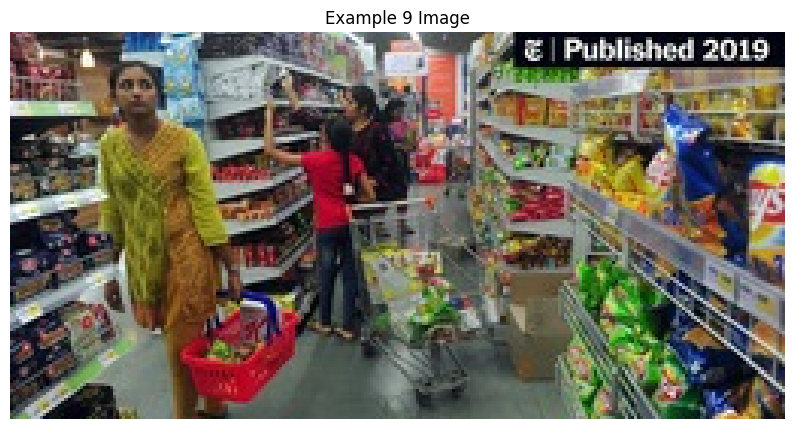

--- Example 9 ---
Original Caption: A supermarket in Mumbai. In India and in other countries, an organization funded by food and beverage companies quietly fights restrictions on sugary or processed foods.
Ground Truth Sections: Health

CNN Predictions (Top 3):
- Movies: 0.2162
- Television: 0.1794
- Books: 0.1726

LSTM Predictions (Top 3):
- Health: 0.6726
- Opinion: 0.1245
- Economy: 0.0459




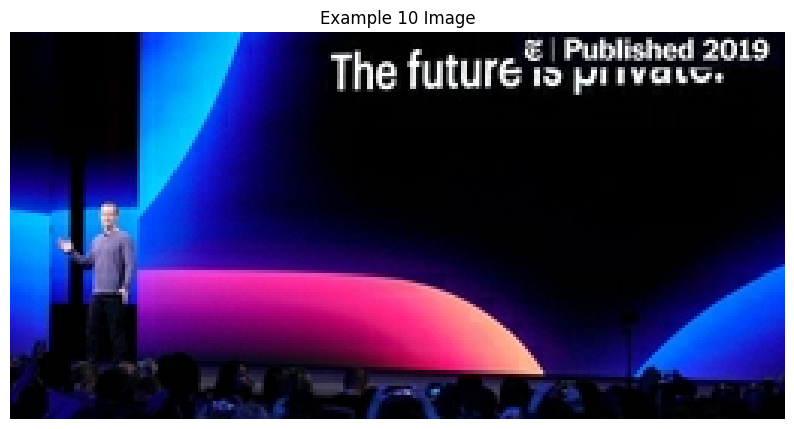

--- Example 10 ---
Original Caption: Mark Zuckerberg, Facebook's chief executive, at a conference in San Jose, Calif., in April. On Wednesday, the Federal Trade Commission placed new conditions on Facebook for privacy violations.
Ground Truth Sections: Technology

CNN Predictions (Top 3):
- Dance: 0.2930
- Music: 0.1516
- Theater: 0.1416

LSTM Predictions (Top 3):
- Technology: 0.9245
- Economy: 0.0091
- Media: 0.0083




In [40]:
for i in range(len(example_indices)):
    # Load and display the original image
    original_image_path = example_img_locs[i]
    img_raw = tf.io.read_file(original_image_path)
    img_decoded = tf.io.decode_image(img_raw, channels=3, expand_animations=False)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_decoded.numpy())
    plt.title(f"Example {i+1} Image")
    plt.axis('off')
    plt.show()

    print(f"--- Example {i+1} ---")
    print(f"Original Caption: {example_captions[i]}")
    print(f"Ground Truth Sections: {', '.join(example_ground_truth_sections[i])}")

    print("\nCNN Predictions (Top 3):")
    for section, score in cnn_top_3_predictions[i]:
        print(f"- {section}: {score:.4f}")

    print("\nLSTM Predictions (Top 3):")
    for section, score in lstm_top_3_predictions[i]:
        print(f"- {section}: {score:.4f}")
    print("\n" + "="*50 + "\n")